

```
# DOMAIN: Botanical Research
• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.
• DATA DESCRIPTION: The dataset comprises of images from 12 plant species.
Source: https://www.kaggle.com/c/plant-seedlings-classification/data.
• PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo.
```



In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.5 MB/s 
     |████████████████████████████████| 1.6 MB 63.6 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
WORK_DIR ='/content/drive/My Drive/Colab/cv/week1-2/Assignment';
os.chdir(WORK_DIR)

In [4]:
from zipfile import ZipFile
import cv2
import pandas as pd
from random  import randint
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
import tensorflow as tf
from tensorflow import keras
from kerastuner import Hyperband
import kerastuner as kerastuner
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, array_to_img
from PIL import Image
from PIL import ImageFilter
import random
from sklearn.decomposition import PCA
import tensorflow as tf
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

np.random.seed(seed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


1. Import and Understand the data [12 Marks]


A. Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python. [2 Marks]

---





In [5]:
PLANT_SEEDLING_PATH = './plant-seedlings-classification.zip'
with ZipFile(PLANT_SEEDLING_PATH, 'r') as zipfile:
  zipfile.extractall()


B. Map the images from train folder with train labels to form a DataFrame. [6 Marks]
---



In [6]:
root = WORK_DIR + '/plant-seedlings-classification/train'
cols = ['Image Name', 'class', 'Actual Image']
N = 4
plant_seed_df = pd.DataFrame(columns = cols)
for path, subdirs, files in os.walk(root):
    for name in files:
        if not name.startswith('.'):
          full_path = os.path.join(path, name);
          #print('Reading path : '+ full_path)
          img = cv2.imread(full_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          plant_seed_df = plant_seed_df.append({'Image Name': name, 'class':os.path.basename(os.path.dirname(full_path)) ,'Actual Image': img},ignore_index=True)

In [7]:
plant_seed_df.head(5)

Image Name     class                                       Actual Image
0  6a4ef17c2.png  Cleavers  [[[72, 61, 45], [73, 66, 50], [49, 47, 28], [4...
1  0515bc601.png  Cleavers  [[[161, 156, 146], [162, 156, 146], [162, 156,...
2  0ac327873.png  Cleavers  [[[91, 78, 67], [88, 73, 63], [88, 74, 63], [9...
3  94f82e916.png  Cleavers  [[[80, 62, 45], [78, 57, 42], [81, 60, 46], [8...
4  2c5c4d127.png  Cleavers  [[[137, 98, 62], [135, 96, 59], [136, 97, 62],...

C. Write a function that will select n random images and display images along with its species. [4 Marks]

---



In [8]:
# generate index of each class 
def generate_random_index(totalNo, total_no_of_records, label):
  random_index = [];
  uniqueLabel = np.unique(label)
  for index , category in  enumerate(uniqueLabel):
    if index >=totalNo:
      break; 
    random_index.append(random.choice(plant_seed_df[plant_seed_df['class'] == category].index))
  while(len(random_index) != totalNo):
    random_index.append(random.randint(0, total_no_of_records));

  return random_index;

In [9]:
# Display Image with label
def displayImage(input,y=None):
  if (isinstance(input, pd.DataFrame)):
    for i in range(len(input)):
      plt.imshow(input.iloc[i, 2])
      plt.xlabel(input.iloc[i, 1])
      plt.show()
  else:
    for i in range(len(input)):
      plt.imshow(input[i])
      plt.xlabel("Actual Label: " + str(y[i]))
      plt.show();

rows selected 


Image Name             class  \
3437  9e2bfa93d.png       Black-grass   
4151  6aae02cb3.png          Charlock   
140   f5608b615.png          Cleavers   
922   a6d54c45c.png  Common Chickweed   
3216  9efa077b7.png      Common wheat   

                                           Actual Image  
3437  [[[65, 52, 50], [68, 56, 54], [68, 58, 55], [6...  
4151  [[[85, 68, 48], [84, 65, 47], [81, 61, 44], [8...  
140   [[[86, 64, 41], [88, 66, 43], [85, 63, 39], [8...  
922   [[[95, 78, 64], [92, 75, 61], [87, 72, 56], [7...  
3216  [[[82, 53, 33], [74, 51, 29], [75, 56, 35], [7...

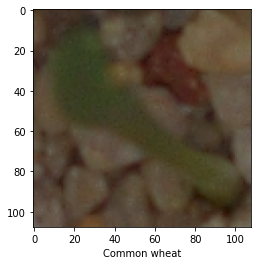

In [10]:
#Select 5 images
TOTAL_NUMBER_OF_RANDOM_IMAGE = 5
# Take ranom 5 index
random_plant_seed_index= generate_random_index(TOTAL_NUMBER_OF_RANDOM_IMAGE, len(plant_seed_df), plant_seed_df['class'])
#Pick up the records based on the dataset
random_plant_seed_df = plant_seed_df.iloc[random_plant_seed_index]
print('rows selected ')
# display it
display(random_plant_seed_df)
# Print the image
displayImage(random_plant_seed_df)

Observations: Images are of un-equal length.

---



### 2. Data preprocessing 

A. Create X & Y from the DataFrame

---



In [11]:
X = plant_seed_df[['Actual Image']]
y = plant_seed_df[['class']]


B. Encode labels of the images

---



In [12]:
label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y.values.ravel())
y_le
y_le = to_categorical(y_le, num_classes = 12)

In [13]:
mapping = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
mapping

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

Use dictionary to find out the name and its corresponding label assigned

C. Unify shape of all the images

---



In [14]:
# Resize the image into 256 x 256
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in X['Actual Image']]

Using randint function select image and check the shape . It should be 256 X 256

In [15]:
rndm_index = randint(1,len(plant_seed_df));
print(rndm_index)
images[rndm_index].shape

1144


(256, 256, 3)



---




D. Normalise all the images. [2 Marks]
---



In [16]:
# Normalise the image and scale it with 0 min value and 1 max value
def normalize(img):
  img = np.expand_dims(img, axis = 0)
  img =img*1/255.0
  return img;

images = [resize_images(img) for img in images]

Checking the min and max of first image. It should be in 0 to 255 range

In [17]:
print('Min pixel  :  ' + str(np.min(images[0])) + '   and  Max pixel  : ' + str(np.max(images[0])))

Min pixel  :  0   and  Max pixel  : 186


3. Model training

      A. Split the data into train and test data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, y_le, test_size=0.20, stratify=y, random_state=1)

In [19]:
# Print the shape of first image 
X_train[0].shape

(256, 256, 3)

In [20]:
y_train.shape

(3800, 12)

In [21]:
#see number of images in each label
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("images shape: ", X_train.shape)
print("classes shape: ", y_train.shape)

images shape:  (3800, 256, 256, 3)
classes shape:  (3800, 12)


In [22]:
# Reducing overfitting by Using data augmentaion, 
train_datagen = ImageDataGenerator(rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.5,  
        height_shift_range=0.5, 
        shear_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=True,fill_mode='nearest')

train_datagen.fit(X_train)

In [23]:
tf.keras.backend.clear_session()

B. Create new CNN architecture to train the model

In [24]:
tf.keras.backend.clear_session()

In [25]:
stop_early = EarlyStopping(monitor='val_loss', mode='min', patience=7)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=0.00001,model='auto')

In [26]:
def build_model(hp):
    model=Sequential();
    model.add(tf.keras.Input(shape=(256,256,3)))
    for layer in range(hp.Int('num_conv_layer', 1,6)):
      model.add(BatchNormalization())
      model.add(Conv2D(filters = hp.Int('conv '+str(layer+1)+'_filter', min_value=32, max_value=128, step=16),kernel_size=hp.Choice('Conv_Kernel_'+str(layer+1), [3,5,7]), padding=hp.Choice('Conv_padding_'+str(layer+1), ['valid','same']) ,
                       activation= "relu" ))
      model.add(BatchNormalization())
      model.add(MaxPooling2D())
  
    model.add(GlobalAveragePooling2D())
    for layer in range(hp.Int('num__dense_layer', 1,4)):
      model.add(BatchNormalization())
      model.add(Dropout(rate=hp.Float('dropout_' + str(layer + 1) ,
                                      min_value=0.0,
                                      max_value=0.5,
                                      step=0.1)))
      model.add(Dense(units=hp.Int("Units_"+str(layer+1), min_value=32, max_value=512, step=64), activation= "relu",  kernel_initializer='he_uniform'))
      model.add(BatchNormalization())
      
    model.add(Dense(units=12,activation='softmax'))
    model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [27]:
tuner  = Hyperband(build_model, objective=kerastuner.Objective("val_accuracy", direction="max"), max_epochs=10, factor=2, hyperparameters=None, directory = 'CNN_project',project_name = 'Q1',overwrite=True)
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_conv_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
conv 1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
Conv_Kernel_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
Conv_padding_1 (Choice)
{'default': 'valid', 'conditions': [], 'values': ['valid', 'same'], 'ordered': False}
num__dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': None}


In [28]:
# tuner.search(train_datagen.flow(X_train,y_train, batch_size=60),validation_data=(X_test,y_test), callbacks=[reduce_lr, stop_early], verbose=2,steps_per_epoch=(X_train.shape[0]/60),use_multiprocessing=True,workers=6)



*   The code has been commented. It is running code, but it is taking 60 min to hypertuned. In order to save time, i save the best hypertuned model into the disk and load it


*   The below code is saving the model into the hard disk





In [29]:
#tuner.results_summary()

In [30]:

# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)
# model.save('Hypertuned_CNN_Prob11.h5')



```
# Above code is used to save the best model into the memory. Since it is taking too much time, so model has been saved and reuse further
```



In [31]:
model = load_model('Hypertuned_CNN_Prob11.h5')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_14 (Bat  (None, 256, 256, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization_15 (Bat  (None, 252, 252, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_16 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                     



```
# Training the hypertuned model with 30 epochs with data agumentatin dataset
```



In [33]:
model_checkpoint = ModelCheckpoint('Hyptun_plantspecies_CNN_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=60),validation_data=(X_test,y_test), callbacks=[reduce_lr, stop_early, model_checkpoint], epochs=30)

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.8856 - accuracy: 0.3932
Epoch 1: val_accuracy improved from -inf to 0.14526, saving model to Hyptun_plantspecies_CNN_model.h5
64/64 [==============================] - 64s 795ms/step - loss: 1.8856 - accuracy: 0.3932 - val_loss: 2.7144 - val_accuracy: 0.1453 - lr: 0.0010
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.5268
Epoch 2: val_accuracy improved from 0.14526 to 0.22105, saving model to Hyptun_plantspecies_CNN_model.h5
64/64 [==============================] - 50s 774ms/step - loss: 1.4177 - accuracy: 0.5268 - val_loss: 2.7655 - val_accuracy: 0.2211 - lr: 0.0010
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 1.1580 - accuracy: 0.6071
Epoch 3: val_accuracy improved from 0.22105 to 0.34000, saving model to Hyptun_plantspecies_CNN_model.h5
64/64 [==============================] - 50s 776ms/step - loss: 1.1580 - accuracy: 0.6071 - val_loss: 2.3353 - val_a



*   Plot the Accuracy and Loss of train and test 




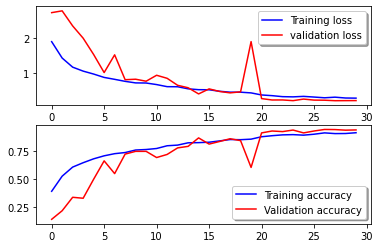

In [34]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [35]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

30/30 [==============================] - 1s 19ms/step - loss: 0.2034 - accuracy: 0.9358
[test loss, test accuracy]: [0.2033836543560028, 0.9357894659042358]


### Model is giving 95% Accuracy 


D. Select a random image and print actual label and predicted label for the same.
---



After expand_dims: (1, 256, 256, 3)


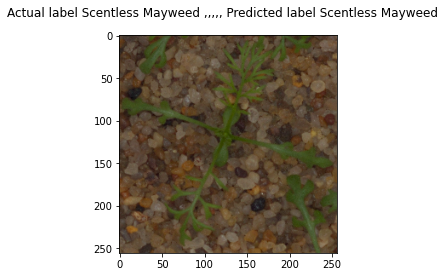

In [36]:
random_number = randint(0,len(X_test))
img = X_test[random_number]
actual_label = y_test[random_number]
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
#img =img*1/255.0
#Check the size of the Image array again
print('After expand_dims: '+ str(img.shape))
result = model.predict(img)
predicted_index = np.argmax(result[0]);
key_list = list(mapping.keys())
val_list = list(mapping.values())
# print key with val 100
position = val_list.index(predicted_index)
predicted = key_list[position]

actual = key_list[np.argmax(actual_label, axis=None, out=None)]
plt.suptitle("Actual label "+ actual +" ,,,,, Predicted label "+predicted)
plt.show()

Removing the variables to free RAM

---



In [37]:
tf.keras.backend.clear_session()
del plant_seed_df, random_plant_seed_index,random_plant_seed_df,X,y, y_le,mapping, rndm_index, images, X_train, X_test, y_train, y_test ,train_datagen, tuner,model, random_number, predicted, actual, key_list,val_list 


DOMAIN: Botanical Research
• CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
species from a photo.
• DATA DESCRIPTION: The dataset comprises of images from 17 plant species.
• PROJECT OBJECTIVE: To experiment with various approaches to train an image classifier to predict type of flower from the image.
---




## 1. Import and Understand the data 
---



A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

---



In [38]:
!pip install tflearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 9.0 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=86dfc472b62765de782855fd2a8610a1f12341b6ebb654f0a6d91eecf921bef3
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [39]:
from tflearn.datasets import oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [40]:
X,y = oxflower17.load_data();

### B. Print Number of images and shape of the images

In [41]:
print("Total Number of images " , len(X))

Total Number of images  1360


Shape of Images

In [42]:
records, height, width, channel =  X.shape
print("Shape" , X.shape)
print("Total number of records ", records)
print(f"pixel {height} x {width} x {channel}")

Shape (1360, 224, 224, 3)
Total number of records  1360
pixel 224 x 224 x 3


C. Print count of each class from y.
---



In [43]:
unique = np.unique(y)
print("unique values are ", unique)
print("Total number of class are ", len(unique))

unique values are  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Total number of class are  17


In [44]:
print("Each class images are ")
classRecord = pd.DataFrame(y).value_counts()
classRecord.columns =['Class', 'No of Records']
classRecord

Each class images are 


0     80
9     80
15    80
14    80
13    80
12    80
11    80
10    80
8     80
1     80
7     80
6     80
5     80
4     80
3     80
2     80
16    80
dtype: int64

Text(0, 0.5, 'Label')

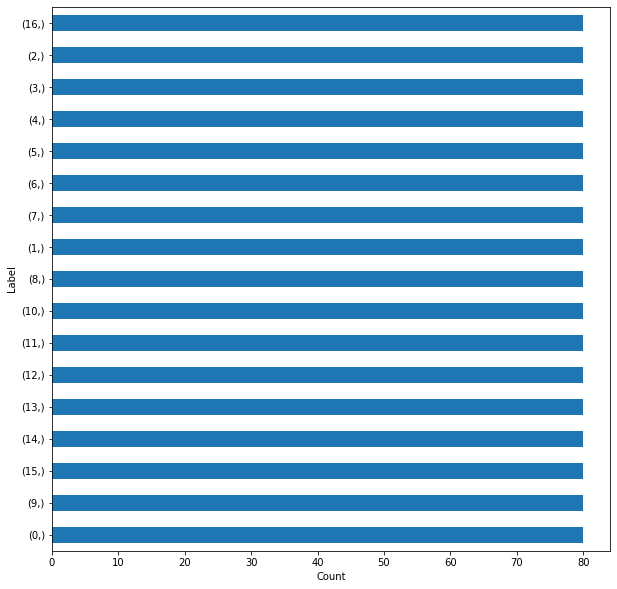

In [45]:
plt.figure(figsize=(10,10))
classRecord.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Label')

## 2. Image Exploration & Transformation [Learning purpose - Not related to final model

A. Display 5 random images

---



In [46]:
# generate index of each class 
def generate_random_index(totalNo, total_no_of_records, label):
  random_index = [];
  label = pd.DataFrame(label)
  label.columns = ['label']
  uniqueLabel = np.unique(label)
  for index , category in  enumerate(uniqueLabel):
    if index >=totalNo:
      break; 
    random_index.append(random.choice(label[label['label'] == category].index))
  while(len(random_index) != totalNo):
    random_index.append(random.randint(0, total_no_of_records));

  return random_index;

rows selected 


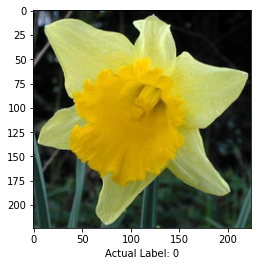

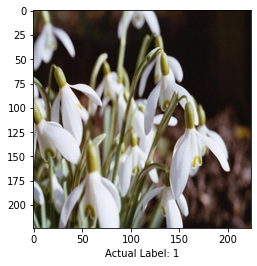

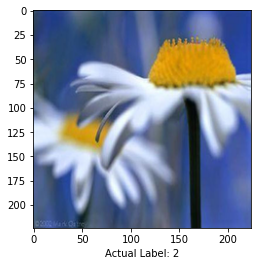

In [47]:
TOTAL_NUMBER_OF_RANDOM_IMAGE = 5
random_flower_index= generate_random_index(TOTAL_NUMBER_OF_RANDOM_IMAGE, len(X), y)
random_flower_X = X[random_flower_index]
random_flower_y = y[random_flower_index]
print('rows selected ')
displayImage(random_flower_X, random_flower_y)

B. Select any image from the dataset and assign it to a variable.
---



(224, 224, 3)

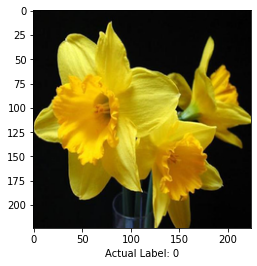

In [48]:
TOTAL_NUMBER_OF_RANDOM_IMAGE =1
random_flower_index= generate_random_index(TOTAL_NUMBER_OF_RANDOM_IMAGE, len(X), y)
random_flower_X = X[random_flower_index]
random_flower_y = y[random_flower_index]
display(random_flower_X[0].shape)
displayImage(random_flower_X, random_flower_y)


C. Transform the image into grayscale format and display the same
---



(1, 224, 224)

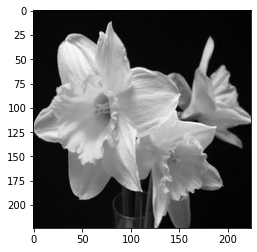

In [49]:
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(random_flower_X[...,:3], rgb_weights)
#plt.imshow(tf.squeeze(grayscale_image))
display(grayscale_image.shape)
plt.imshow(np.squeeze(grayscale_image),cmap='gray')

D. Apply a filter to sharpen the image and display the image before and after sharpening.

---



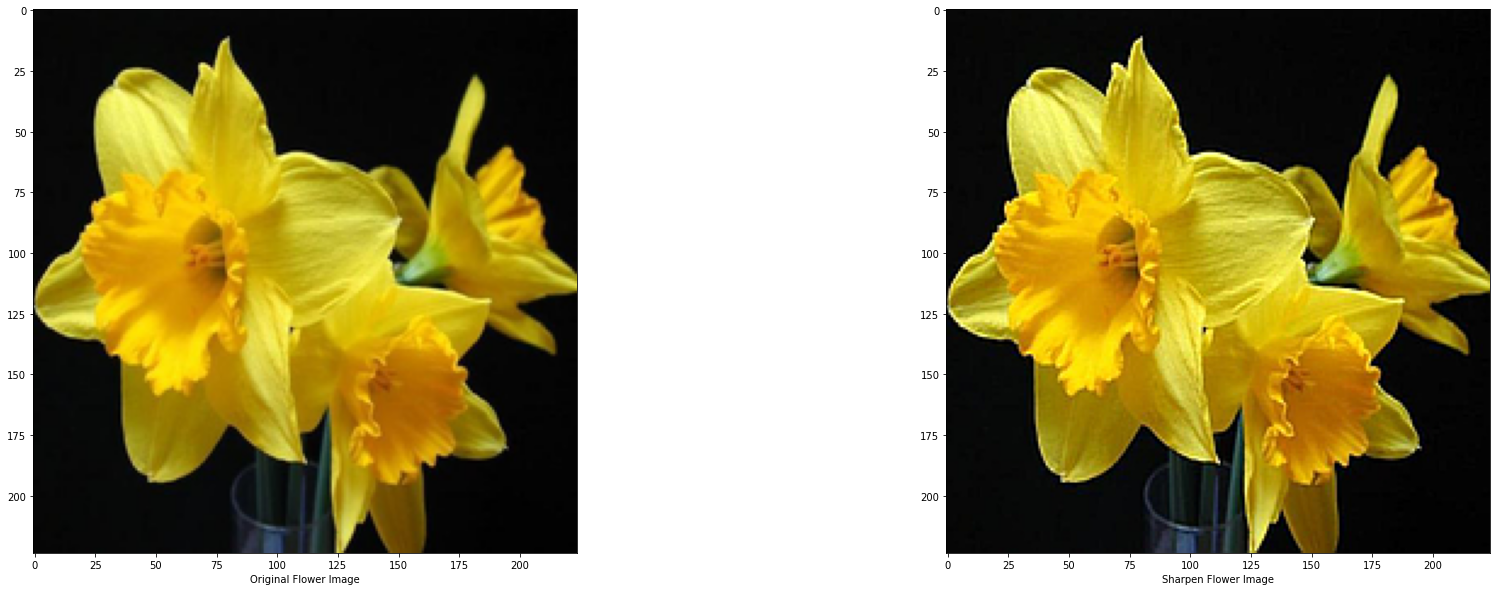

In [50]:
img_pil = tf.keras.utils.array_to_img(random_flower_X[0])
# Apply sharp filter
sharpened1 = img_pil.filter(ImageFilter.SHARPEN);


fig, (ax1,ax2) = plt.subplots(1,2 ,figsize= (30,10))
ax1.imshow(img_pil)
ax1.set_xlabel("Original Flower Image")
ax2.imshow(sharpened1)
ax2.set_xlabel("Sharpen Flower Image");


# E. Apply a filter to blur the image and display the image before and after blur. [2 Marks]


---





Text(0.5, 0, 'Sharpening Flower Image')

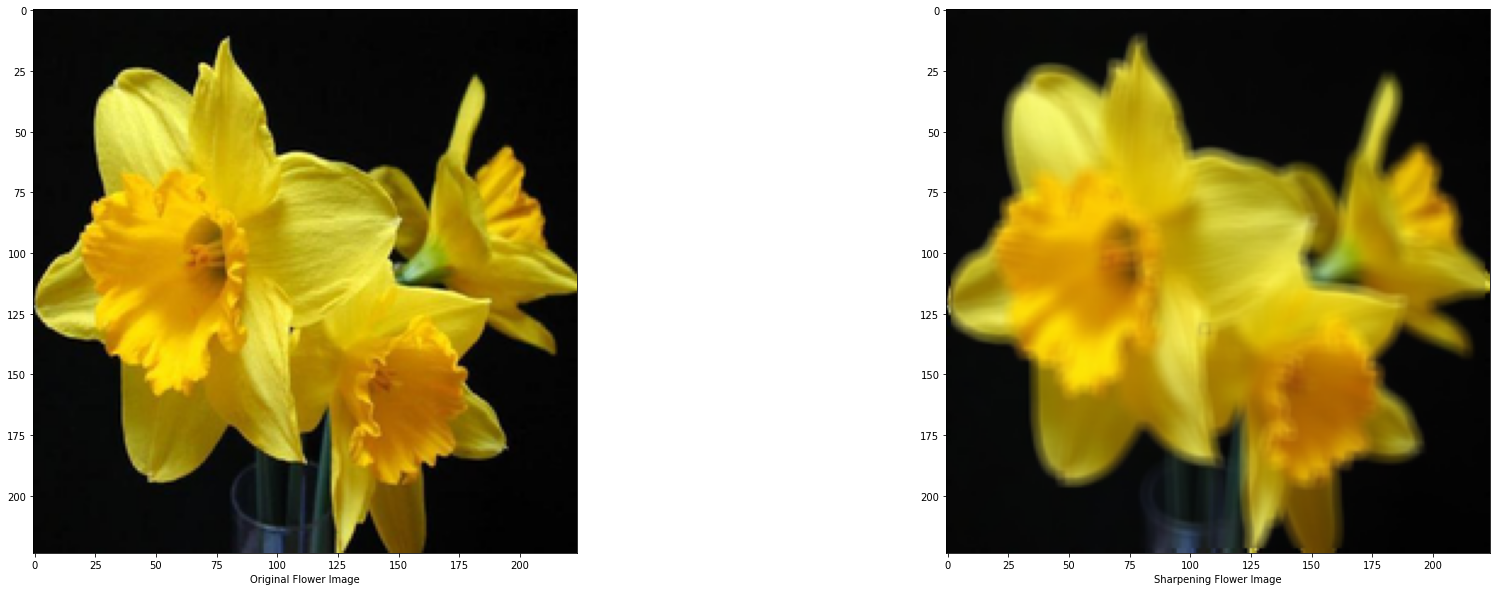

In [51]:
# Apply sharp filter
blur1 = img_pil.filter(ImageFilter.BLUR);

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize= (30,10))
ax1.imshow(img_pil)
ax1.set_xlabel("Original Flower Image")
ax2.imshow(blur1)
ax2.set_xlabel("Sharpening Flower Image")


F. Display all the 4 images from above questions besides each other to observe the difference. [1 Marks]

---





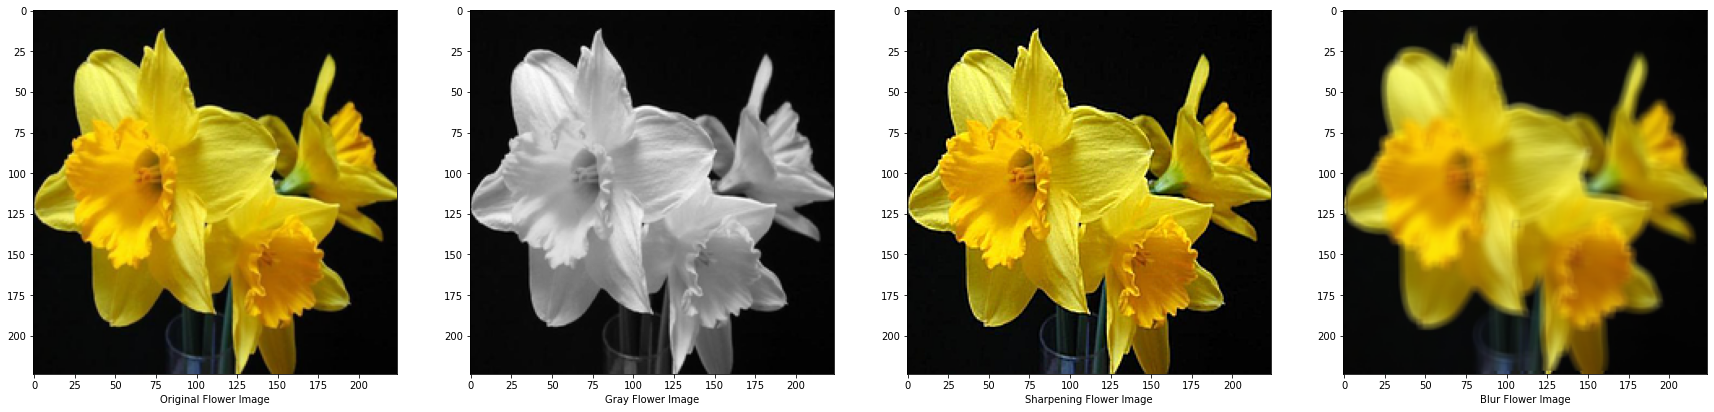

In [52]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4 ,figsize= (30,10))
ax1.imshow(img_pil)
ax1.set_xlabel("Original Flower Image")
ax2.imshow(np.squeeze(grayscale_image),cmap='gray')
ax2.set_xlabel("Gray Flower Image")
ax3.imshow(sharpened1)
ax3.set_xlabel("Sharpening Flower Image")
ax4.imshow(blur1)
ax4.set_xlabel("Blur Flower Image");



```
# Printing each category of images.
```



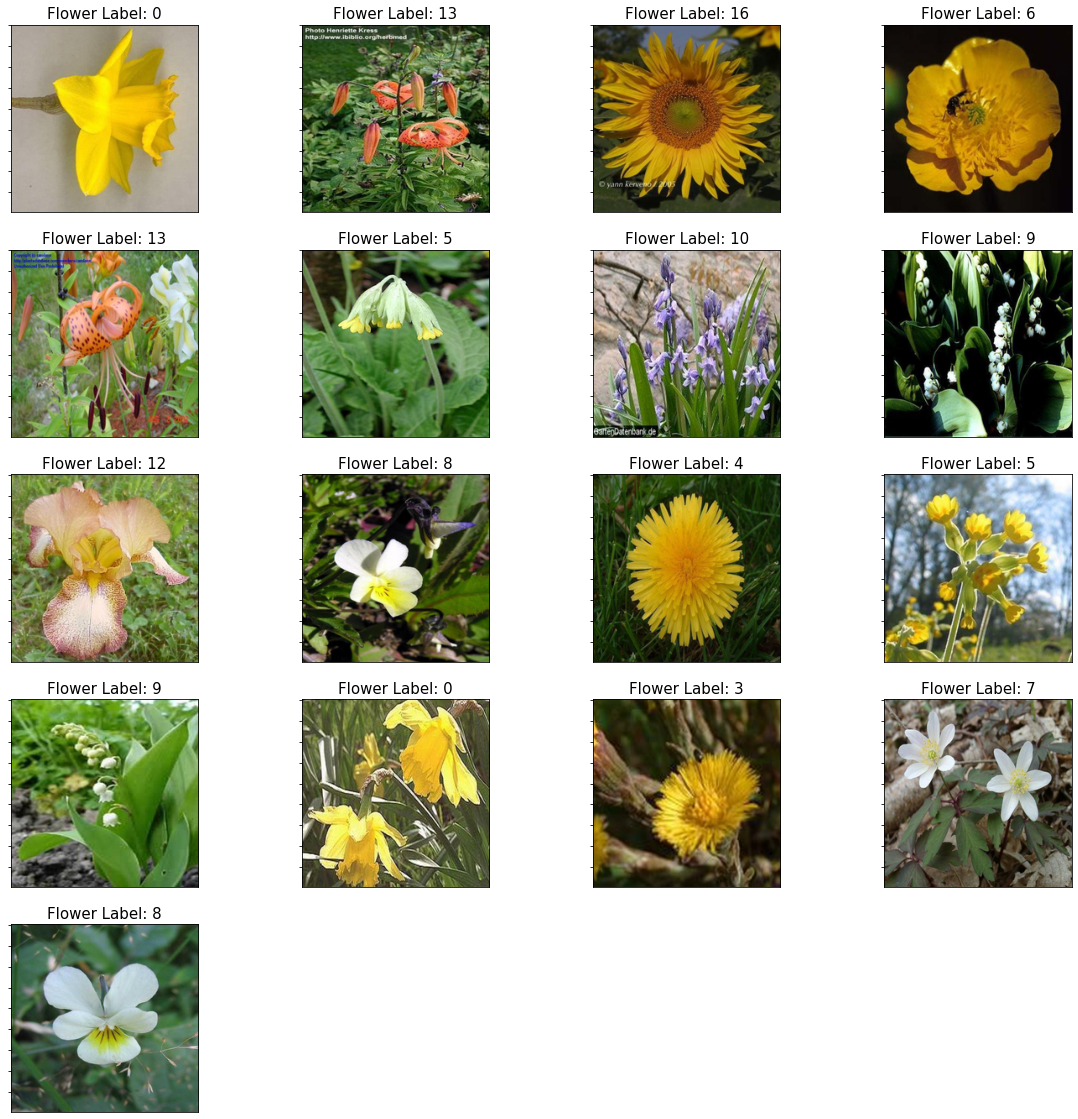

In [53]:
plt.figure(figsize = (20,20))
col =1
for i in np.unique(y):
    plt.subplot(5,4,col)
    plt.imshow(X[i])
    plt.title(f"Flower Label: {y[i]}",{'fontsize':15})
    plt.tick_params(top=False,bottom=False,right=False,labelleft = False,labelbottom=False)
    col = col+1
plt.show()


## 3. Model training and Tuning:



A. Split the data into train and test with 80:20 proportion

---



In [54]:
X_train, X_test, y_train ,y_test = train_test_split(X,y , test_size=0.20, random_state=seed)

B. Train a model using any Supervised Learning algorithm and share performance metrics on test data

---



In [55]:
result = {}

In [56]:
# Flatten the layer
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [57]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)

In [58]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,


((1088, 50176), (1088, 50176), (1088, 50176))

In [59]:
X_test_r.shape, X_test_g.shape, X_test_b.shape,

((272, 50176), (272, 50176), (272, 50176))

In [60]:
n_components = 200
X_train_r_pca = PCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_g_pca = PCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_b_pca = PCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_r_pca = PCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_g_pca = PCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_b_pca = PCA(n_components=n_components, whiten=True).fit(X_test_b)

In [61]:
X_train_r_pca.explained_variance_ratio_.sum(), X_train_g_pca.explained_variance_ratio_.sum(), X_train_b_pca.explained_variance_ratio_.sum()

(0.84574187, 0.8352584, 0.864336)

In [62]:
X_test_r_pca.explained_variance_ratio_.sum(), X_test_g_pca.explained_variance_ratio_.sum(), X_test_b_pca.explained_variance_ratio_.sum()

(0.9689964, 0.9675413, 0.9781177)

In [63]:
Xr_train_pca = X_train_r_pca.transform(X_train_r)
Xg_train_pca = X_train_g_pca.transform(X_train_g)
Xb_train_pca = X_train_b_pca.transform(X_train_b)

Xr_test_pca = X_test_r_pca.transform(X_test_r)
Xg_test_pca = X_test_g_pca.transform(X_test_g)
Xb_test_pca = X_test_b_pca.transform(X_test_b)

In [64]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)


In [65]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,

((272, 600), (272,))

In [66]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [67]:
rf_score = clf.score(X_test_pca, y_test)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"The predicted label is:'{rf_accuracy}'")
result['Random Forest']  = ['NA', rf_accuracy, clf]

The predicted label is:'0.17279411764705882'


In [68]:
del X_train_pca,X_test_pca

C. Train a model using Neural Network and share performance metrics on test data

---



In [69]:
print('Shape of X_train ' ,X_train.shape)
print('Shape of y_train ' ,y_train.shape)

print('Shape of X_test ' ,X_test.shape)
print('Shape of y_test ' ,y_test.shape)

Shape of X_train  (1088, 224, 224, 3)
Shape of y_train  (1088,)
Shape of X_test  (272, 224, 224, 3)
Shape of y_test  (272,)


Convert the label into desired CNN format

In [70]:
num_of_classes=len(np.unique(y_train))
print(num_of_classes)
y_train_cal = to_categorical(y_train,num_classes=num_of_classes)
y_test_cal = to_categorical(y_test, num_classes=num_of_classes)

17


In [71]:
train_datagen =   ImageDataGenerator(rotation_range=180,  
        zoom_range=0.3,
        width_shift_range=0.3,  
        height_shift_range=0.3, 
        shear_range=0.3, 
        horizontal_flip=True,  
        vertical_flip=True,
        fill_mode='nearest',
        )
test_datagen = ImageDataGenerator()
train_datagen.fit(X_train)
#test_datagen.fit(X_test)
batch_size = 64
train_datagen = train_datagen.flow(X_train, y_train_cal, batch_size=batch_size)

validation_set = test_datagen.flow(X_test, y_test_cal, batch_size=batch_size)

In [72]:
from keras.backend import reshape
from tensorflow import keras
tf.keras.backend.clear_session()
def build_model(hp):
  model = Sequential()
  model.add(keras.layers.InputLayer(input_shape=(224, 224, 3)))
  model.add(Flatten())
  for layer in range(hp.Int('num_layer', 1,4)):
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int("Units_"+str(layer+1), min_value=32, max_value=1024, step=32), activation= hp.Choice('activation_' +str(layer+1), ["relu"]),  kernel_initializer='he_uniform' ))
    model.add(Dropout(rate=hp.Float('dropout_' + str(layer + 1) ,
                                    min_value=0.0,
                                    max_value=0.5,
                                    step=0.1)))
  model.add(BatchNormalization())
  model.add(Dense(units=num_of_classes, activation='softmax'))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
  model.compile(optimizer=Adam(learning_rate=learning_rate),loss=CategoricalCrossentropy(),metrics=['accuracy'])
  return model

In [73]:
tuner  = Hyperband(build_model, objective=kerastuner.Objective("val_acc", direction="max"), max_epochs=15, factor=2, hyperparameters=None, directory = 'Flower_NN_Q2',project_name = 'Tuning_MODEL_NN',overwrite=True)
tuner.search_space_summary()

Instructions for updating:
Colocations handled automatically by placer.


Search space summary
Default search space size: 5
num_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': None}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu'], 'ordered': False}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [74]:
stop_early = EarlyStopping(monitor='val_loss', mode='min', patience=7)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=0.00001,model='auto', verbose=1)

In [75]:
tuner.search(train_datagen,validation_data=(X_test,y_test_cal), steps_per_epoch=X_train.shape[0]/ batch_size)

Trial 46 Complete [00h 02m 53s]
val_acc: 0.3639705777168274

Best val_acc So Far: 0.3897058963775635
Total elapsed time: 00h 47m 49s


In [76]:
best_ANN_model = tuner.get_best_models()[0]
best_ANN_model.build(X_train.shape)
# Saving model into the memory
best_ANN_model.save('Hypertuned_ANN_Flower_Prob2.h5')
best_ANN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 batch_normalization (BatchN  (None, 150528)           602112    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 576)               86704704  
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 576)              2304      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 17)                9

It took 60 min to hypertuned the model.
Model has been saved so that it can be reuse again with again doing hypertuning


In [77]:
# Loading model from the memory
best_ANN_model = load_model('Hypertuned_ANN_Flower_Prob2.h5')
best_ANN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 batch_normalization (BatchN  (None, 150528)           602112    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 576)               86704704  
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 576)              2304      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 17)                9

In [78]:
# Train the model with 50 epochs
checkpoint_nn = ModelCheckpoint("tflearn_ANN_Flower.h5",monitor='val_acc', mode='max',verbose=1, save_best_only=True)
history_ANN_hypertuned = best_ANN_model.fit(train_datagen, validation_data=(X_test,y_test_cal), callbacks=[reduce_lr,stop_early, checkpoint_nn], epochs=50, verbose=2, steps_per_epoch=X_train.shape[0]/ 64)

Epoch 1/50

Epoch 1: val_acc improved from -inf to 0.33824, saving model to tflearn_ANN_Flower.h5
17/17 - 16s - loss: 2.4783 - acc: 0.2316 - val_loss: 2.0496 - val_acc: 0.3382 - lr: 1.7102e-04 - 16s/epoch - 914ms/step
Epoch 2/50

Epoch 2: val_acc did not improve from 0.33824
17/17 - 8s - loss: 2.4284 - acc: 0.2454 - val_loss: 2.0707 - val_acc: 0.3162 - lr: 1.7102e-04 - 8s/epoch - 450ms/step
Epoch 3/50

Epoch 3: val_acc improved from 0.33824 to 0.34191, saving model to tflearn_ANN_Flower.h5
17/17 - 14s - loss: 2.4084 - acc: 0.2482 - val_loss: 1.9774 - val_acc: 0.3419 - lr: 1.7102e-04 - 14s/epoch - 819ms/step
Epoch 4/50

Epoch 4: val_acc did not improve from 0.34191
17/17 - 7s - loss: 2.3560 - acc: 0.2518 - val_loss: 2.0025 - val_acc: 0.3309 - lr: 1.7102e-04 - 7s/epoch - 438ms/step
Epoch 5/50

Epoch 5: val_acc improved from 0.34191 to 0.38971, saving model to tflearn_ANN_Flower.h5
17/17 - 14s - loss: 2.2753 - acc: 0.2748 - val_loss: 1.9057 - val_acc: 0.3897 - lr: 1.7102e-04 - 14s/epoch -

In [79]:
y_pre = best_ANN_model.predict(X_test)
y_pred_final=[]
for i in y_pre:
  y_pred_final.append(np.argmax(i))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [80]:
loss, accuracy = best_ANN_model.evaluate(X_test, y_test_cal)
result['ANN']  = [loss, accuracy, best_ANN_model]
print('loss in Testing data ', loss)
print('Accuracy in Testing data ', accuracy)

loss in Testing data  1.7479017762576832
Accuracy in Testing data  0.44117647


Accuracy is 44% . Lets try CNN 

Text(69.0, 0.5, 'Predicted')

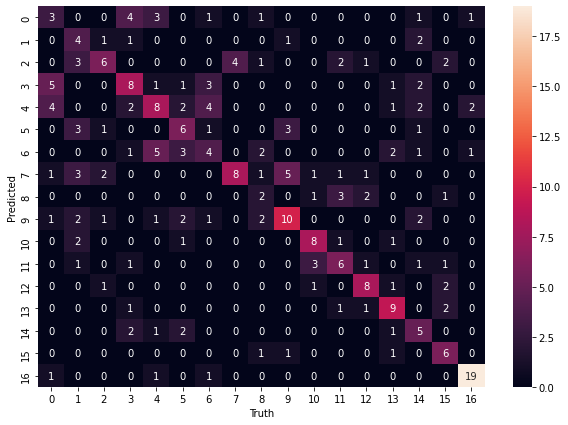

In [81]:
# Printing the confusion metrics
cm = confusion_matrix(y_pred_final,y_test)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')

## Observation: Model is bad in predicting 14,12,8, 6,3,1,0.
## Printing the classification report

In [82]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.21      0.20      0.21        15
           1       0.44      0.22      0.30        18
           2       0.32      0.50      0.39        12
           3       0.38      0.40      0.39        20
           4       0.32      0.40      0.36        20
           5       0.40      0.35      0.38        17
           6       0.21      0.27      0.24        15
           7       0.35      0.67      0.46        12
           8       0.22      0.20      0.21        10
           9       0.45      0.50      0.48        20
          10       0.62      0.57      0.59        14
          11       0.43      0.43      0.43        14
          12       0.62      0.57      0.59        14
          13       0.64      0.53      0.58        17
          14       0.45      0.29      0.36        17
          15       0.67      0.43      0.52        14
          16       0.86      0.83      0.84        23

    accuracy              



```
# F1 score is less for each class. Overall accuracy  is 44%
```



In [83]:
#  displaying the Accuracy and Loss of model
def show_final_history(history):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title("Loss")
    ax[1].set_title("Accuracy")
    ax[0].plot(history.history["loss"],label="Loss")
    ax[0].plot(history.history["val_loss"],label="Test Loss")
    ax[1].plot(history.history["acc"],label="Accuracy")
    ax[1].plot(history.history["val_acc"],label="Test Accuracy")
    
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")

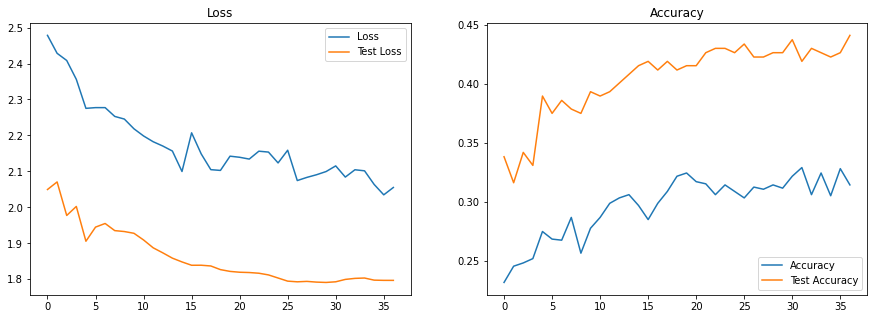

In [84]:
show_final_history(history_ANN_hypertuned)

D. Train a model using a basic CNN and share performance metrics on test data

---



In [85]:
tf.keras.backend.clear_session()



```
# Hypertuning CNN model
```



In [86]:
def build_model(hp):
    model=Sequential();
    model.add(tf.keras.Input(shape=(224,224,3)))
    for layer in range(hp.Int('num_conv_layer', 1,5)):
      model.add(BatchNormalization())
      model.add(Conv2D(filters = hp.Int('conv '+str(layer+1)+'_filter', min_value=32, max_value=128, step=16),kernel_size=hp.Choice('Conv_Kernel_'+str(layer+1), [3,5,7]), padding=hp.Choice('Conv_padding_'+str(layer+1), ['valid','same']) ,
                       activation= "relu" ))
      model.add(BatchNormalization())
      model.add(MaxPooling2D())
  
    model.add(GlobalAveragePooling2D())
    for layer in range(hp.Int('num__dense_layer', 1,4)):
      model.add(BatchNormalization())
      model.add(Dropout(rate=hp.Float('dropout_' + str(layer + 1) ,
                                      min_value=0.0,
                                      max_value=0.5,
                                      step=0.1)))
      model.add(Dense(units=hp.Int("Units_"+str(layer+1), min_value=32, max_value=512, step=64), activation= "relu",  kernel_initializer='he_uniform'))
      model.add(BatchNormalization())
      
    model.add(Dense(units=num_of_classes,activation='softmax'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model
    

In [87]:
tuner  = Hyperband(build_model, objective=kerastuner.Objective("val_acc", direction="max"), max_epochs=15, factor=2, hyperparameters=None, directory = 'Flower_NN_Q2',project_name = 'TUNING_MODEL_CNN',overwrite=True)
tuner.search_space_summary()

Search space summary
Default search space size: 8
num_conv_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
conv 1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
Conv_Kernel_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
Conv_padding_1 (Choice)
{'default': 'valid', 'conditions': [], 'values': ['valid', 'same'], 'ordered': False}
num__dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': None}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [88]:
print("images shape: ", X_train.shape)
print("classes shape: ", y_train.shape)

images shape:  (1088, 224, 224, 3)
classes shape:  (1088,)


In [89]:
# tuner.search(train_datagen,
#                     steps_per_epoch=(X_train.shape[0]/batch_size),
#                     validation_data=(X_test, y_test_cal) 
#              )

In [90]:
# best_CNN_model = tuner.get_best_models()[0]
# best_CNN_model.build(X_train.shape)
# best_CNN_model.summary()
# best_CNN_model.save('Hypertuned_Flower_CNN_Prob2.h5')
# best_CNN_model.summary()

### It is taking more than 1 hours. So i am using the already Saved model

In [91]:
best_CNN_model = load_model('Hypertuned_Flower_CNN_Prob2.h5')
best_CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 80)      6080      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 80)     320       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 80)     0         
 )                                                               
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 80)     320       
 hNormalization)                                        

In [92]:
#Training the model with 50 epochs
checkpoint_cnn = ModelCheckpoint("tflearn_CNN_.h5",monitor='val_acc',
                             mode='max',verbose=1, save_best_only=True)
history_hypertuned = best_CNN_model.fit(train_datagen, validation_data=(X_test, y_test_cal), callbacks=[reduce_lr, stop_early,checkpoint_cnn], epochs=50,  verbose=2)
#history_hypertuned = best_CNN_model.fit(X_train, y_train_cal, validation_data=(X_test, y_test_cal), callbacks=[reduce_lr, stop_early,checkpoint_cnn], epochs=100,  verbose=2, batch_size=64)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_acc improved from -inf to 0.26103, saving model to tflearn_CNN_.h5
17/17 - 13s - loss: 1.7160 - acc: 0.4430 - val_loss: 4.2869 - val_acc: 0.2610 - lr: 0.0046 - 13s/epoch - 742ms/step
Epoch 2/50

Epoch 2: val_acc improved from 0.26103 to 0.33456, saving model to tflearn_CNN_.h5
17/17 - 9s - loss: 1.5600 - acc: 0.4632 - val_loss: 4.4501 - val_acc: 0.3346 - lr: 0.0046 - 9s/epoch - 550ms/step
Epoch 3/50

Epoch 3: val_acc improved from 0.33456 to 0.35662, saving model to tflearn_CNN_.h5
17/17 - 10s - loss: 1.4599 - acc: 0.5221 - val_loss: 4.1043 - val_acc: 0.3566 - lr: 0.0046 - 10s/epoch - 603ms/step
Epoch 4/50

Epoch 4: val_acc improved from 0.35662 to 0.37500, saving model to tflearn_CNN_.h5
17/17 - 10s - loss: 1.4004 - acc: 0.5221 - val_loss: 4.2635 - val_acc: 0.3750 - lr: 0.0046 - 10s/epoch - 603ms/step
Epoch 5/50

Epoch 5: val_acc did not improve from 0.37500
17/17 - 10s - loss: 1.4352 - acc: 0.5064 - val_loss: 3.1416 - val_acc: 0.3750 - lr: 0.0046 - 10s/epoch - 599ms/ste

In [93]:
y_pre = best_CNN_model.predict(X_test)
y_pred_final=[]
for i in y_pre:
  y_pred_final.append(np.argmax(i))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [94]:
loss, accuracy = best_CNN_model.evaluate(X_test, y_test_cal)
result['CNN']  = [loss, accuracy, best_CNN_model]
print('loss in Testing data ', loss)
print('Accuracy in Testing data ', accuracy)


loss in Testing data  0.8670400591457591
Accuracy in Testing data  0.69485295


Text(69.0, 0.5, 'Predicted')

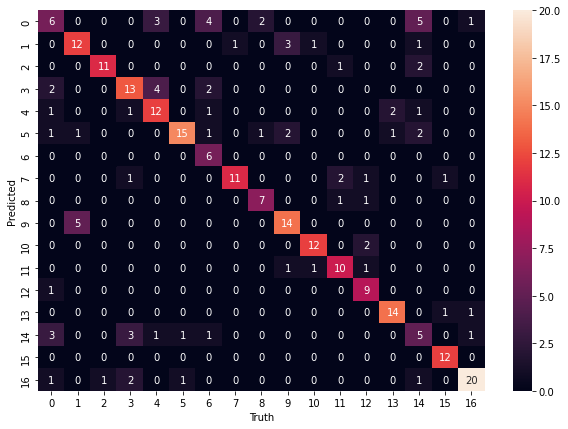

In [95]:
cm = confusion_matrix(y_pred_final,y_test)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Truth')
plt.ylabel('Predicted')


In [96]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.29      0.40      0.33        15
           1       0.67      0.67      0.67        18
           2       0.79      0.92      0.85        12
           3       0.62      0.65      0.63        20
           4       0.67      0.60      0.63        20
           5       0.62      0.88      0.73        17
           6       1.00      0.40      0.57        15
           7       0.69      0.92      0.79        12
           8       0.78      0.70      0.74        10
           9       0.74      0.70      0.72        20
          10       0.86      0.86      0.86        14
          11       0.77      0.71      0.74        14
          12       0.90      0.64      0.75        14
          13       0.88      0.82      0.85        17
          14       0.33      0.29      0.31        17
          15       1.00      0.86      0.92        14
          16       0.77      0.87      0.82        23

    accuracy              

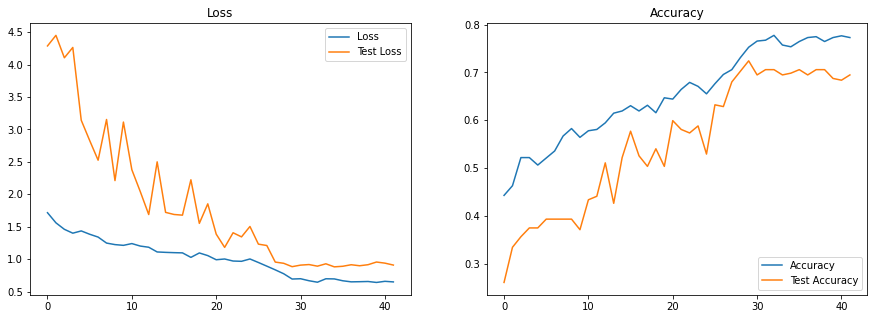

In [97]:
show_final_history(history_hypertuned)



*   Loss for training data is less than testing,
*   Accuracy of Test is less than training..
*   Need to add more data or dropout layer to avoid overfitting.


Loss for training is less than testing.



In [98]:
#Printing the result of all model and take the better one
result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],    # make a dataframe out of the metrics from result dictionary 
                       columns= ['Loss','accuracy'],
                      index= result.keys())   # use the model names as index

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'
result1

Loss  accuracy
Model                            
Random Forest        NA  0.172794
ANN            1.747902  0.441176
CNN             0.86704  0.694853


Observation: 




*   1) CNN model is giving the best accuracy.
*   2) Loss is very less
*   3) Moving with CNN to predict the images



E. Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label.

---



In [99]:
model = result['CNN'][2]

After expand_dims: (1, 224, 224, 3)


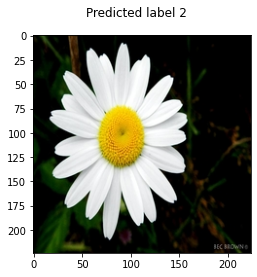

In [100]:
img  = WORK_DIR + '/Prediction.jpg'
predicted_img = cv2.imread(img)
predicted_img = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2RGB)
predicted_img = predicted_img/255
predicted_img = np.expand_dims(predicted_img, axis = 0)
#img =img*1/255.0
#Check the size of the Image array again
print('After expand_dims: '+ str(predicted_img.shape))
result = model.predict(predicted_img)
predicted_index = np.argmax(result[0]);
plt.imshow(np.squeeze(predicted_img))
plt.suptitle('Predicted label '+str(predicted_index))
plt.show();

Obseravation : 
The image are pr**edicted with LABEL 2**

---

